LAB M. 105 API Calling to ChatGPT
Cindy Lund

API lab! In this exercise, you'll learn how to integrate OpenAI's ChatGPT API into your applications. Specifically, you'll use GPT-4 Vision to analyze product images and generate professional product listings.

What you'll build:

An automated product listing generator
Integration with OpenAI's ChatGPT API
Image analysis using vision models
Error handling and best practices

In [53]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [54]:
pip install openai

Note: you may need to restart the kernel to use updated packages.


In [55]:
from datasets import load_dataset

ds = load_dataset("ashraq/fashion-product-images-small") 
                  

In [56]:
pip install Pillow


Note: you may need to restart the kernel to use updated packages.


In [57]:
import PIL
print(PIL.__version__)


12.1.0


In [58]:
# Install: pip install datasets
from datasets import load_dataset
from pathlib import Path
from PIL import Image
import pandas as pd

print("Loading product dataset...")


Loading product dataset...


In [59]:
try:
    # Try loading the dataset - a small slice
    dataset = load_dataset("ashraq/fashion-product-images-small", split="train[:100]")  # First 100 samples
    print(f"✓ Loaded {len(dataset)} products")
    
    # Convert to pandas for easier manipulation making a dataframe
    products_df = pd.DataFrame(dataset)
    print(f"Dataset columns: {products_df.columns.tolist()}")
    

    # quick sanity check: is the image usable?
    print("Image type:", type(dataset[0]["image"]))
 
except Exception as e:
    print(f"⚠ Could not load HuggingFace dataset: {e}")
    print("Using local images instead...")

    # Create a folder to save images
    images_dir = Path("product_images")
    images_dir.mkdir(exist_ok=True)
    print(f"\n✓ Dataset prepared!")
    print(f"  Total products: {len(products_df)}")

  


✓ Loaded 100 products
Dataset columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image']
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [60]:
# Display the first few rows of the products dataframe to verify it loaded correctly
products_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.Image.Image image mode=L size=60x80 at 0x...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.Image.Image image mode=RGB size=60x80 at ...


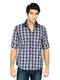

In [61]:
# Display the first product's image to verify it loaded correctly
product = products_df.iloc[0]
display(product["image"])

In [62]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

In [63]:
import base64
from io import BytesIO

# Take ONE product image
image = products_df.iloc[0]["image"]   # PIL Image

# Encode image to base64
buffer = BytesIO()
image.save(buffer, format="JPEG")
image_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

# Checkpoint: verify encoding worked
print("✓ Image encoded successfully")
print("Base64 length:", len(image_base64))
print("Preview:", image_base64[:100])


✓ Image encoded successfully
Base64 length: 2388
Preview: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx


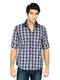

In [64]:
# to see if image loaded correctly, which means it is encoded correctly
from IPython.display import display
display(products_df.iloc[0]["image"])

In [65]:
# NEW  remove if code does not work. This is code to make product descriptions more unique added
#Cell 1: Style + personas + prefix tracking helper
import random

# 1) Style rules (no banning, just uniqueness)
STYLE_RULES = """
Writing rules:
- Make the first sentence feel different from previous products (vary the opening).
- Keep it specific to what you see (color/material/pattern/brand cues).
- Avoid repeating the same opener phrase across products when possible.
"""

# 2) Optional personas (adds variety)
PERSONAS = [
    "Tone: modern minimalist, crisp and factual.",
    "Tone: sporty and energetic, performance-focused.",
    "Tone: premium/heritage, refined and timeless.",
    "Tone: playful and friendly, upbeat but not cheesy."
]

def pick_persona(seed_text: str) -> str:
    # stable-ish choice per product name (reruns stay consistent)
    rng = random.Random(seed_text)
    return rng.choice(PERSONAS)

# 3) Track openings (first N words) to reduce repetition
def description_prefix(text: str, n_words: int = 8) -> str:
    words = (text or "").replace("\n", " ").split()
    return " ".join(words[:n_words]).strip().lower()

used_prefixes = set()


In [49]:
#UPDATED to include Style and Personas based product description generation
def create_product_listing_prompt(product, price=None, avoid_prefixes=None):
    """
    Create a prompt for generating product listings.
    """

    # 1) Extract raw fields
    product_name = product.get("productDisplayName", "")
    gender = product.get("gender", "")
    article_type = product.get("articleType", "")

    # 2) Derived fields
    category = f"{gender} {article_type}".strip()

    price_line = (
        f"- Price: ${price:.2f}"
        if price is not None
        else ""
    )

    # 3) Prompt
    prompt = f"""You are an expert e-commerce copywriter. Analyze the product image and create a compelling product listing.

Product Information:
- Name: {product_name}
- Category: {category}
{price_line}

Please create a professional product listing that includes:

1. **Product Title** (catchy, SEO-friendly, 60 characters max)
2. **Product Description** (detailed, 150-200 words)
   - Highlight key features and benefits
   - Use persuasive language
   - Include relevant details visible in the image
3. **Key Features** (bullet points, 5-7 items)
4. **SEO Keywords** (comma-separated, 10-15 relevant keywords)

Format your response as JSON with the following structure:
{{
    "title": "Product title here",
    "description": "Full description here",
    "features": ["Feature 1", "Feature 2"],
    "keywords": "keyword1, keyword2"
}}

Be specific about what you see in the image. Mention colors, materials, design elements, and any distinctive features.

Return ONLY valid JSON.
"""
    return prompt



In [66]:
test_prompt = create_product_listing_prompt(
    products_df.iloc[0],
    price=79.99
)

print("\n" + "="*50)
print("PROMPT TEMPLATE (preview)")
print("="*50)
print(test_prompt[:500] + "...")


PROMPT TEMPLATE (preview)
You are an expert e-commerce copywriter. Analyze the product image and create a compelling product listing.

Product Information:
- Name: Turtle Check Men Navy Blue Shirt
- Category: Men Shirts
- Price: $79.99

Please create a professional product listing that includes:

1. **Product Title** (catchy, SEO-friendly, 60 characters max)
2. **Product Description** (detailed, 150-200 words)
   - Highlight key features and benefits
   - Use persuasive language
   - Include relevant details visible in t...


In [67]:
# First Vision API call (image + prompt → JSON)
import os, json
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 1) Pick one product + build prompt. Revised with avoid reusing same opening phrases by tracking used prefixes
product = products_df.iloc[0]
prompt = create_product_listing_prompt(product, avoid_prefixes=used_prefixes)

# 2) Get the image (PIL) and encode
import base64
from io import BytesIO

img = product["image"]  # PIL image
buf = BytesIO()
img.save(buf, format="JPEG")
image_base64 = base64.b64encode(buf.getvalue()).decode("utf-8")

# 3) Call OpenAI Vision
resp = client.responses.create(
    model="gpt-4o-mini",
    input=[{
        "role": "user",
        "content": [
            {"type": "input_text", "text": prompt},
            {"type": "input_image", "image_url": f"data:image/jpeg;base64,{image_base64}"}
        ]
    }]
)

# 4) Extract and parse JSON
raw_text = resp.output_text.strip()

# Remove ```json ... ``` or ``` ... ``` wrappers if present
if raw_text.startswith("```"):
    raw_text = raw_text.split("```", 2)[1]
    raw_text = raw_text.replace("json", "", 1).strip()
    if "```" in raw_text:
        raw_text = raw_text.split("```", 1)[0].strip()

print("Raw response preview:", raw_text[:200], "...\n")

listing = json.loads(raw_text)
print("✓ Parsed JSON keys:", listing.keys())
listing


Raw response preview: {
    "title": "Navy Blue Turtle Check Men’s Shirt - Stylish & Comfortable",
    "description": "Elevate your wardrobe with our Turtle Check Men Navy Blue Shirt, where classic design meets modern styl ...

✓ Parsed JSON keys: dict_keys(['title', 'description', 'features', 'keywords'])


{'title': 'Navy Blue Turtle Check Men’s Shirt - Stylish & Comfortable',
 'description': 'Elevate your wardrobe with our Turtle Check Men Navy Blue Shirt, where classic design meets modern style. Tailored to perfection, this shirt features a striking navy blue check pattern that adds a touch of sophistication to any casual or semi-formal occasion. Made from breathable cotton fabric, it ensures all-day comfort while keeping you stylish. The short sleeves and classic collar create a relaxed yet trendy vibe, making it perfect for a summer outing or a laid-back office environment. Pair it with your favorite jeans or chinos for an effortlessly chic look. Durable and easy to care for, this shirt is a must-have in every man’s wardrobe.',
 'features': ['Stylish navy blue check pattern',
  'Breathable cotton material for comfort',
  'Short sleeves for a relaxed fit',
  'Classic collar design',
  'Versatile for casual and semi-formal occasions',
  'Easy to care for and maintain',
  'Available in 

In [68]:
#revised with used prefixes to avoid repetition in product descriptions. This is a simple heuristic and can be improved with more advanced NLP techniques if needed.
#Step 6: Processing multiple products in a batch with error handling and saving results
import os, json, time
import pandas as pd
import base64
from io import BytesIO
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def pil_to_base64_jpeg(pil_img) -> str:
    buf = BytesIO()
    pil_img.save(buf, format="JPEG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def parse_json_from_model_text(raw_text: str) -> dict:
    raw_text = raw_text.strip()

    # Handle markdown code fences if the model adds them
    if raw_text.startswith("```"):
        raw_text = raw_text.split("```", 2)[1]
        raw_text = raw_text.replace("json", "", 1).strip()
        if "```" in raw_text:
            raw_text = raw_text.split("```", 1)[0].strip()

    return json.loads(raw_text)

def generate_listing_for_product(product_row, max_retries=2, sleep_seconds=1.0):
    prompt = create_product_listing_prompt(product_row)  # uses your Step 4 function
    img_b64 = pil_to_base64_jpeg(product_row["image"])

    last_err = None
    for attempt in range(max_retries + 1):
        try:
            resp = client.responses.create(
                model="gpt-4o-mini",
                input=[{
                    "role": "user",
                    "content": [
                        {"type": "input_text", "text": prompt},
                        {"type": "input_image", "image_url": f"data:image/jpeg;base64,{img_b64}"}
                    ]
                }]
            )
            listing = parse_json_from_model_text(resp.output_text)
            return listing, None

        except Exception as e:
            last_err = str(e)
            time.sleep(sleep_seconds)

    return None, last_err


# ===== Batch processing =====
N = 10  # start small; increase later (e.g., 50, 100)
results = []

for i in range(min(N, len(products_df))):
    product = products_df.iloc[i]

    product_id = product.get("id", None)
    name = product.get("productDisplayName", "")
    gender = product.get("gender", "")
    article_type = product.get("articleType", "")

    listing, err = generate_listing_for_product(product)

    if err is None:
        used_prefixes.add(
        description_prefix(listing.get("description", ""))
        )
        results.append({
            "id": product_id,
            "productDisplayName": name,
            "gender": gender,
            "articleType": article_type,
            "title": listing.get("title", ""),
            "description": listing.get("description", ""),
            "features": listing.get("features", []),
            "keywords": listing.get("keywords", ""),
            "status": "ok",
            "error": ""
        })
        print(f"✓ {i+1}/{N} OK — {name[:60]}")
    else:
        results.append({
            "id": product_id,
            "productDisplayName": name,
            "gender": gender,
            "articleType": article_type,
            "title": "",
            "description": "",
            "features": [],
            "keywords": "",
            "status": "error",
            "error": err
        })
        print(f"⚠ {i+1}/{N} ERROR — {name[:60]} — {err[:120]}")

# ===== Save results =====
results_df = pd.DataFrame(results)

# 1) Save as JSON Lines (best for structured + lists)
jsonl_path = "product_listings.jsonl"
with open(jsonl_path, "w", encoding="utf-8") as f:
    for row in results:
        f.write(json.dumps(row, ensure_ascii=False, default=str) + "\n")

# 2) Save as CSV (features list becomes a string)
csv_path = "product_listings.csv"
results_df.assign(features=results_df["features"].apply(lambda x: "; ".join(x) if isinstance(x, list) else str(x))) \
          .to_csv(csv_path, index=False, encoding="utf-8")

print("\n✓ Batch complete")
print("Saved:", jsonl_path, "and", csv_path)
print("Summary:\n", results_df["status"].value_counts())
results_df.head()


✓ 1/10 OK — Turtle Check Men Navy Blue Shirt
✓ 2/10 OK — Peter England Men Party Blue Jeans
✓ 3/10 OK — Titan Women Silver Watch
✓ 4/10 OK — Manchester United Men Solid Black Track Pants
✓ 5/10 OK — Puma Men Grey T-shirt
✓ 6/10 OK — Inkfruit Mens Chain Reaction T-shirt
✓ 7/10 OK — Fabindia Men Striped Green Shirt
✓ 8/10 OK — Jealous 21 Women Purple Shirt
✓ 9/10 OK — Puma Men Pack of 3 Socks
✓ 10/10 OK — Skagen Men Black Watch

✓ Batch complete
Saved: product_listings.jsonl and product_listings.csv
Summary:
 status
ok    10
Name: count, dtype: int64


,id,productDisplayName,gender,articleType,title,description,features,keywords,status,error
0,15970,Turtle Check Men Navy Blue Shirt,Men,Shirts,Stylish Turtle Check Men Navy Blue Shirt,Elevate your wardrobe with the Turtle Check Me...,"[Premium cotton fabric for ultimate comfort, E...","men shirt, navy blue shirt, check pattern shir...",ok,
1,39386,Peter England Men Party Blue Jeans,Men,Jeans,Trendy Peter England Blue Jeans for Men - Perf...,Step out in confidence with the Peter England ...,"[Rich blue color for versatile styling, Tailor...","Peter England jeans, men's blue jeans, party j...",ok,
2,59263,Titan Women Silver Watch,Women,Watches,Elegant Titan Women Silver Watch for Stylish S...,Discover timeless elegance with the Titan Wome...,[Sleek stainless steel construction for durabi...,"Titan watch, women's silver watch, elegant wom...",ok,
3,21379,Manchester United Men Solid Black Track Pants,Men,Track Pants,Stylish Black Manchester United Men Track Pants,Elevate your casual wardrobe with these Manche...,"[Made from soft, breathable fabric for comfort...","Manchester United, men track pants, black trac...",ok,
4,53759,Puma Men Grey T-shirt,Men,Tshirts,Stylish Puma Men Grey T-shirt – Perfect for Ev...,Elevate your casual style with the Puma Men Gr...,"[Premium cotton blend for ultimate comfort, Tr...","Puma T-shirt, men's grey t-shirt, casual wear,...",ok,
